<div style="text-align: right">INFO 6105 Data Sci Engineering Methods and Tools, Lecture 9 Day 2</div>
<div style="text-align: right">Dino Konstantopoulos, 5 November 2020, with material from Peter Norvig and Chris Fonnesbeck</div>

# Bayesian Statistical Analysis

***Bayesian*** statistics is not just a particular statistical method. It is a *completely different, modern, and very successful paradigm* for doing statistical analysis. It is different from ***frequentist*** statistics, and this is what we'll investigate and contrast in this notebook.

A Bayesian model is described by ***parameters*** and ***uncertainty*** in those parameters. The model is described as ***probability distributions***, which we had time to experiment with. Uncertainly in its parameters is *also* described as probability distributions. That is why you need a solid foundation in probability theory in data science.

In the case of Big Data, we have so much data that we know **exactly** what the probability distributions may be. Uncertainties not required. Frequentist statistics work great in these use cases.

Oftentimes however, even in the case of Big Data, there are conditions where **not enough data is available**, e.g. snowing with sun glare and white trucks. That is when accidents happen with autonomous vehicles!

<br />
<center>
    <img src="ipynb.images/autonomous.png" width=400 />
</center>

Run the cell below, we'll use it.

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

RANDOM_SEED = 20090425

## Lab: Spying on my girlfriend

Ok, let's do some ***real*** data science now. I have *important* problems to think of! Will you help me ***spy*** on my girlfriend to make sure she does not swap me for a better model of a boyfriend? 

<br />
<center>
    <img src="ipynb.images/dastardly-spying.png" width=300 />
</center>

Actually, i'll give you the data. You just do the data science to tell me she is still faithful to me, ok?

Instead of variational inference, we are going to leverage [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) (MCMC)
methods to model data. Running the [Metropolis](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm (one *example* of an MCMC algorithm) may crash your kernel if your laptop is not powerful enough! But is'a good example of probabilistic data science (and *soooo* useful), so let's take a closer look.

If you agree, we'll try to model the rate at which my girlfriend sends and receives text messages, to better
understand underlying dynamics. For example, it is well known that President Trump sends
most of his Twitterstorms early in the morning. What can I infer from my girlfriend's cell phone activity,
without actually looking at its content?

>  You are given a series of daily text-message counts from my girlfriend. The data, plotted over time, appears in the chart below. I am curious to know if my girlfriend's text-messaging habits have changed over time, either gradually or suddenly. How to model this? 

Let's plot some data. First, download `mcmc.zip` from blackboard, unzip `txtdata.csv` and the two other images it contains a new folder called `data` in your Users folder. 

You can leverage linux commands either through `!` or *magic commands* which start with `%`. Use `%pwd` to check your current directory and `%cd /Enter/your/prefered/path/here/` to change it. It should be `Users\<username>`. Then run the following script:

```python
figsize(12.5, 3.5)
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did my girlfriend's texting habits change over time?")
plt.xlim(0, n_count_data);
```


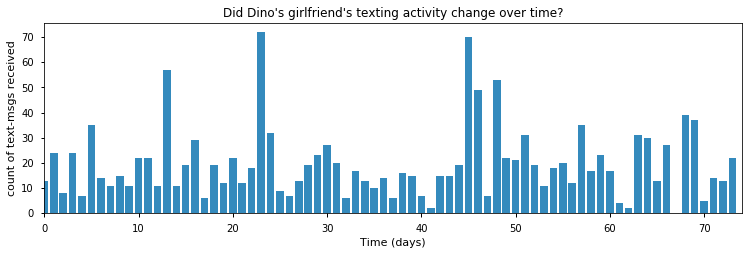

In [27]:
from IPython.core.pylabtools import figsize
figsize(12.5, 3.5)
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did Dino's girlfriend's texting activity change over time?")
plt.xlim(0, n_count_data);

Before we start modeling this data (more exactly, the process underlying this data), see what you can figure out just by looking at the chart above. Would you say there was a change in behaviour during this time period? 

<center>
    <img src="ipynb.images/garfield.jpg" width=150 />
</center>

How can we start to model this? A Poisson random variable is a more appropriate model for this type of *count* data, since count is discrete and count cannot go to infinity and is bounded by the most text messages received in one day. Denoting my girlfriend's day $i$'s text-message count by $C_i$, 

$$ C_i \sim \text{Poisson}(\lambda)  $$

We are not sure what the value of the $\lambda$ parameter really is, however. Looking at the chart above, it appears that the rate might become higher later in the observation period, which is equivalent to saying that $\lambda$ increases at some point during the observations (for discrete processes, expectation is equal to $\lambda$; thus a higher value of $\lambda$ assigns higher probability to larger outcomes. That is, there is a higher probability of many text messages having been sent on a given day).

How can we represent this observation mathematically? Let's build a model! 

<center>
    <img src="ipynb.images/buildmodel.png" width=400 />
</center>

Let's assume that on some day during the observation period (call it $\tau$), the parameter $\lambda$ suddenly jumps to a higher value, because my girlfriend has .. *met someone*.. Yikes! So we really have two $\lambda$ parameters: one for the period before $\tau$, and one for the rest of the observation period. In literature, a sudden transition like this is called a *switchpoint*; values of $\lambda$ before $\tau$ are called *anterior* distributions, and values after, *posterior*.

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

If, in reality, no sudden change occurred and indeed $\lambda_1 = \lambda_2$, then the $\lambda$s posterior distributions should look about equal.

We are interested in inferring the unknown $\lambda$s. To use Bayesian inference, we need to assign prior probabilities to the different possible values of $\lambda$. What would be good prior probability distributions for $\lambda_1$ and $\lambda_2$? Recall that $\lambda$ can be any positive number. As we saw earlier, the *exponential* distribution provides a continuous density function for positive numbers, so it might be a good choice for modeling $\lambda_i$. 

<span style="color:red">Don't get confused.. we are still using the Poisson distribution for modeling the distribution of text messages received, but we will use the exponential distribution for modeling the $\lambda$ of the Poisson distribution. Oh my!</span>

Recall that the exponential distribution takes a parameter of its own, so we'll need to include that parameter in our model. Let's call that parameter $\alpha$. Rememeber, model parameters are always denoted by *greek* letters.

\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}

$\alpha$ is called a *hyper-parameter* or *parent variable*. In literal terms, it is a parameter that influences other parameters. 

Our initial guess at $\alpha$ should not influence the model too strongly, and we should have some flexibility in our choice.  A good hyperparameter rule of thumb is to set the exponential parameter equal to the inverse of the average of the count data. Since we're modeling $\lambda$ using an exponential distribution, we can use the expected value identity shown earlier to get:

$$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E\;[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$ 

A sound (er?) alternative would be to have *two* priors: one for each $\lambda_i$. Creating two exponential distributions with different $\alpha$ values reflects our prior belief that the rate changed at some point during the observations.

What about $\tau$? Because of the noisiness of the data, it's difficult to pick out a priori when $\tau$ might have occurred. Instead, we can assign a *uniform prior belief* to every possible day. This is equivalent to saying

\begin{align}
& \tau \sim \text{DiscreteUniform(1, 70) }\\\\
& \Rightarrow P( \tau = k ) = \frac{1}{70}
\end{align}

We now turn to `PyMC3`. 

In [28]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)

    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

In the code above, we create the PyMC3 variables corresponding to $\lambda_1$ and $\lambda_2$. We assign them to PyMC3's *stochastic variables*, so-called because they are treated by the back end as random number generators. And we hope we get no errors, because there is serious computation going on here, so please be patient. Then, run the following..

In [29]:
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

This code creates a new function `lambda_`, but really we can think of it as a random variable: the random variable $\lambda$ from above. The `switch()` function assigns `lambda_1` or `lambda_2` as the value of `lambda_`, depending on what side of `tau` we are on. The values of `lambda_` up until `tau` are `lambda_1` and the values afterwards are `lambda_2`.

Note that because `lambda_1`, `lambda_2` and `tau` are random, `lambda_` will be random. We are **not** fixing any variables yet.

In [30]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

The variable `observation` combines our data, `count_data`, with our proposed data-generation scheme, given by the variable `lambda_`, through the `observed` keyword. 

The code below is a *learning* step. It's really a machine learning method. The machinery employed is called *Markov Chain Monte Carlo* (MCMC). This technique returns thousands of random variables from the posterior distributions of $\lambda_1, \lambda_2$ and $\tau$. 

The [Metropolis–Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm)
algorithm is a Markov chain Monte Carlo (MCMC) method for obtaining a sequence of random
samples from a probability distribution for which direct sampling is difficult.

The algorithm was named after Nicholas Metropolis, who was an author along with Edward Teller of
the 1953 paper [Equation of State Calculations by Fast Computing Machines](https://bayes.wustl.edu/Manual/EquationOfState.pdf), which first proposed
the algorithm for the case of symmetrical proposal distributions, and W. K. Hastings who extended it
to the more general case in 1970. Nicholas Metropolis had already coined the term "Monte Carlo" in
an earlier paper with Stanislav Ulam, was intimately familiar with the computational aspects of the
method and also lead the group that designed and built the [MANIAC I](https://en.wikipedia.org/wiki/MANIAC_I) computer in 1952, which was used in the experiments. MANIAC 1 could be thought of as the first Data Science computer.

We plot a histogram of the random variables to see what the posterior distributions look like. Below, we collect the samples (called *traces* in the MCMC literature) into histograms. 

Depending on the step size you pick below as parameters to `pm.sample`, this code could potentially crash your Jupyter kernel.

<br />
<center>
<img src="http://currentsurroundings.com/content/random/calvin-hobbes/large/calvin_and_hobbes_067.jpg" width = 150>
</center>

In [31]:
### Metropolis-Hastings simulation
with model:
    step = pm.Metropolis()
    trace = pm.sample(4000, tune=1000, step=step, njobs = 1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
100%|██████████| 5000/5000 [00:02<00:00, 2394.17it/s]
The number of effective samples is smaller than 25% for some parameters.


If you crashed, you should have a yellow `connecting to kernel` or red `stopped` status bar at the top of your notebook. That means you are *hosed* and will not be able to execute any more cells. Oh well.. nice try.. go watch an episode of GoT and come back and.. replace your pm.sample() call with:
```python
trace = pm.sample(3000, tune=800, step=step, njobs = 1)
```
Some other things to try is to reduce 4000 and the `tune` parameter even more.. but then your algorithm might not converge, so find a point at which it works but does nto converge, and keep increasing the parameters untill Metroplois converges. Then carry on..

In [32]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

Now we are ready to plot the posterior distributions of our model parameters:

D:\Anaconda3.5.1\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


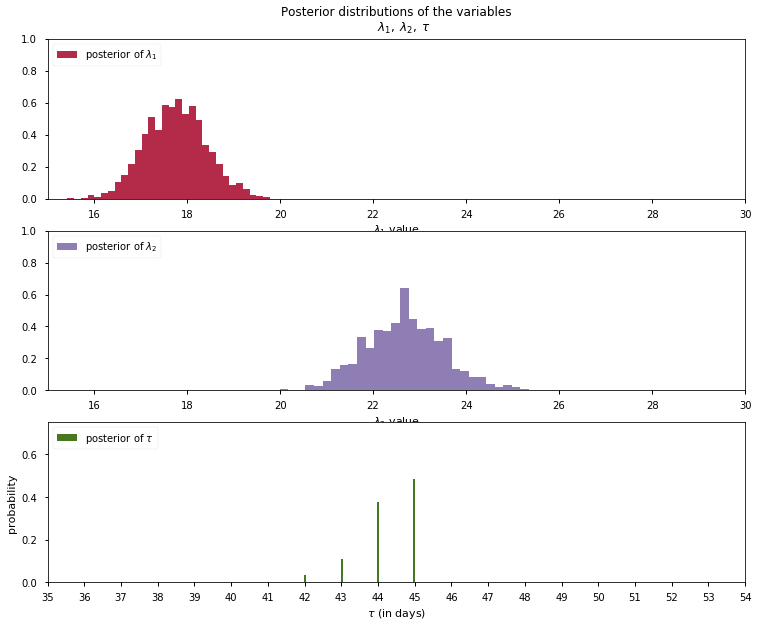

In [33]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

### Interpretation

Recall that Bayesian methodology returns a *distribution*. Hence we now have distributions to describe the unknown $\lambda$s and $\tau$. What have we gained? Immediately, we can see the uncertainty in our estimates: the wider the distribution (the more choice of $\lambda$), the less certain our posterior belief should be. But we can also see what the plausible values for the parameters are: $\lambda_1$ should be around 18 and $\lambda_2$ around 23. The posterior distributions of the two $\lambda$s are clearly distinct, indicating that it is *indeed likely* that there was a change in my girlfriend's text-message behaviour.

Notice also that the posterior distributions for the $\lambda$s do not look like exponential distributions, even though our priors for these variables were exponential. In fact, the posterior distributions are not really of any form that we recognize from the original model. They look like normal distributions! It leads me to believe that I should have picked normal distributions for these priors. But if I do and get the same result, it;s ok! This is one of the benefits of taking a computational point of view. If we had instead done this analysis using mathematical approaches, we would have been stuck with an analytically intractable position. Our use of a computational approach makes us indifferent to mathematical tractability.

Our analysis also returned a distribution for $\tau$. Its posterior distribution looks a little different from the other two because it is a *discrete* random variable, so it doesn't assign probabilities to intervals. We can see that near day 45, there is a close to 50% chance that my girlfriend's texting behaviour changed! Had no change occurred, or had the change been gradual over time, the posterior distribution of $\tau$ would have been more spread out, reflecting that many days were plausible candidates for $\tau$. By contrast, in the actual results we see that only three or four days make any sense as potential transition points. 

Nice! (well, not very nice for me..)

### Why do I want to sample the posterior, anyways?

We use posterior sampling to answer the following question: what is the expected number of texts at day $t, \; 0 \le t \le 70$ ? Recall that the expected value of a Poisson variable is equal to its parameter $\lambda$. Therefore, the question is equivalent to *what is the expected value of $\lambda$ at time $t$*?

In the code below, let $i$ index samples from the posterior distributions. Given a day $t$, we average over all possible $\lambda_i$ for that day $t$, using $\lambda_i = \lambda_{1,i}$ if $t \lt \tau_i$ (that is, if the behaviour change has not yet occurred), else we use $\lambda_i = \lambda_{2,i}$.

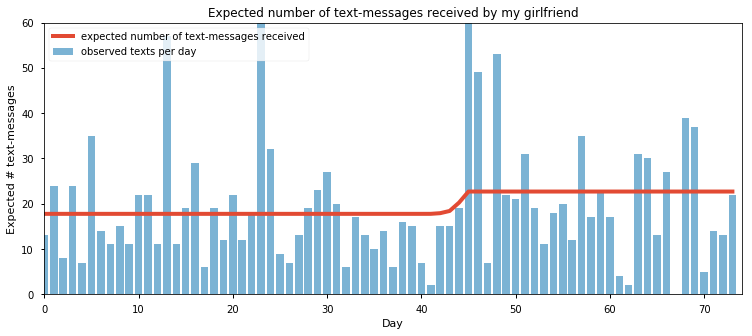

In [34]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received by my girlfriend")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

Your analysis shows strong support for believing my girlfriend's behavior *did* change ($\lambda_1$ would have been close in value to $\lambda_2$ had this not been true), and that the change was sudden rather than gradual (as demonstrated by $\tau$'s strongly peaked posterior distribution). We can only speculate what might have caused this: Perhaps a new relationship?! If i weren't a data scientist, I might have been fooled!

>**Note**: But more importantly, nowhere in my analysis did I ever inject any *bias* in my model! That is what being a modern data scientist si all about. One day, maybe you will help devise the algorithms to program robocops, and your data scientist career was born with INFO 6105!

>**Note**: It is also interesting that you don't really have to scan for *content* to figure out dynamics involving content. You can just use probability and statistics and start *counting* to unearth events. This is how US government is running its domestic (and probably foreign, too) surveillance program. It does not need to spy on your cell phone conversations, but it most certainly catalogues the *amount* of texts and phone calls and can probably trace their origin and in some cases connect you to potentially *shady* characters, and *then* start surveilling your messages and conversations...

And as far as i'm concerned..

<center>
    <img src="ipynb.images/cry.png" width=200 />
</center>

## Conclusion

The most difficult part of Bayesian estimation is the part that models the parameters of the pdf you picked as your model as pdfs themselves. 

You might think that it's picking the right statistical profile that matches the histogram of the dataset, but that's usually not that hard. Picking the shape of the pdf for each model parameter is *harder* because you don't have a physical profile to match! 

And then, you also need to pick initial conditions for these parameters!

It's all about experience! If you ***make the right choices*** (and that is often the *art* behind Bayesian inference), then Bayesian packages like `PyMc3` will do all the work for you, and you will get a good **model** of your dataset, and then you can throw away all the historical data and use that model to do predictions.

Machine Learning is similar to Bayesian estimation in that you need to guess a lot of hyperparameters for the machine model (this is why yours truly loves Random forests because there are so few associated hyperparameters). 

Most ML algorithms however won't yield estimations of the guessing error, which Bayesian estimation methods ***do*** yield. And that becomes very important when a machine tells you to do something ***scary***. *Ummm... are you sure you want me to accelerate to 120 mph? What's the statistical error in your prediction?* 

You want to be able to ask these questions from machines! And that is why ***Bayesian*** ML is, today, the state of the art in ML.

## References and Resources

- Goodman, S. N. (1999). Toward evidence-based medical statistics. 1: The P value fallacy. Annals of Internal Medicine, 130(12), 995–1004. http://doi.org/10.7326/0003-4819-130-12-199906150-00008
- Johnson, D. (1999). The insignificance of statistical significance testing. Journal of Wildlife Management, 63(3), 763–772.
- Gelman, A., Carlin, J. B., Stern, H. S., Dunson, D. B., Vehtari, A., & Rubin, D. B. (2013). Bayesian Data Analysis, Third Edition. CRC Press.
-  Norvig, Peter. 2009. [The Unreasonable Effectiveness of Data](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/35179.pdf).
- Salvatier, J, Wiecki TV, and Fonnesbeck C. (2016) Probabilistic programming in Python using PyMC3. *PeerJ Computer Science* 2:e55 <https://doi.org/10.7717/peerj-cs.55>
- Cronin, Beau. "Why Probabilistic Programming Matters." 24 Mar 2013. Google, Online Posting to Google . Web. 24 Mar. 2013. <https://plus.google.com/u/0/107971134877020469960/posts/KpeRdJKR6Z1>.